# Introduction



### Purpose

The primary purpose of this notebook is to introduce you to the exciting world of deep learning, with a specific focus on CNNs. CNNs have revolutionized computer vision tasks and are widely used for image classification, object detection, and more. By carrying out this notebook, you will be able to:

1. **Understand CNN Fundamentals:** Gain a solid grasp of the key concepts and components that make up Convolutional Neural Networks.

2. **Implement a Simple CNN:** Learn how to create a basic CNN architecture using PyTorch, a popular deep learning framework.

3. **Train and Evaluate the Model:** Walk through the process of training your CNN on a dataset and evaluating its performance.

4. **Apply Knowledge to Real-World Problems:** Acquire the skills necessary to apply CNNs to real-world image classification tasks, setting the stage for more advanced deep learning applications.

### Notebook Content

This notebook is organized into several sections, each building upon the previous one to provide a structured learning experience. Here's a brief overview of what you can expect in each section:

1. **Introduction to Convolutional Neural Networks (CNNs):** We'll start by reminding the fundamental concepts behind CNNs, including convolutional layers, pooling layers, and fully connected layers (recap in class).

2. **Dataset Preparation:** Proper data preparation is crucial for training deep learning models. In this section, we'll cover how to load and preprocess your dataset.

3. **Building the CNN Architecture:** You'll learn how to design a simple CNN architecture using PyTorch. We'll define the model's structure, including convolutional layers, activation functions, and fully connected layers.

4. **Training the CNN:** We'll delve into the training process, where you'll discover how to train your CNN using the prepared dataset. You'll explore loss functions, optimizers, and monitor the training progress.

5. **Model Evaluation and Testing:** After training, it's essential to assess your model's performance. We'll show you how to evaluate your CNN on test data, calculate accuracy, and visualize results.

6. **Conclusion and Future Work:** We'll conclude the notebook by summarizing what you've learned and suggesting potential avenues for further exploration in the world of deep learning and CNNs.

This Hw was completed with the help of chatgpt

## 1.2 Imports

In [23]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# check which version we are using
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


# 2. Dataset preparation: the MedMNIST dataset

In this notebook, we will use the MedMNIST dataset, which, according to the official [reference](https://medmnist.com/) is *"a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. All images are pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with the corresponding classification labels, so that no background knowledge is required for users. Covering primary data modalities in biomedical images, MedMNIST v2 is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label)."*

In [25]:
## Uncomment the following line of code the first time that you run
## work with this dataset in order to install it.
#!pip install medmnist

In [26]:
data_flag = 'bloodmnist'
download = True

# mode, parameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [27]:
## preprocessing - we will transform the data to tensors and
## normalize them (remember that for working with NNs we 
## always need to work with normalized dataset)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)



Using downloaded and verified file: /Users/sebastianballesteros/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/sebastianballesteros/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/sebastianballesteros/.medmnist/bloodmnist.npz


In [28]:
first_batch = next(iter(val_loader))

first_batch[0].shape

torch.Size([128, 3, 28, 28])

In [29]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /Users/sebastianballesteros/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Li

In [30]:
# visualization
train_dataset.montage(length=1)

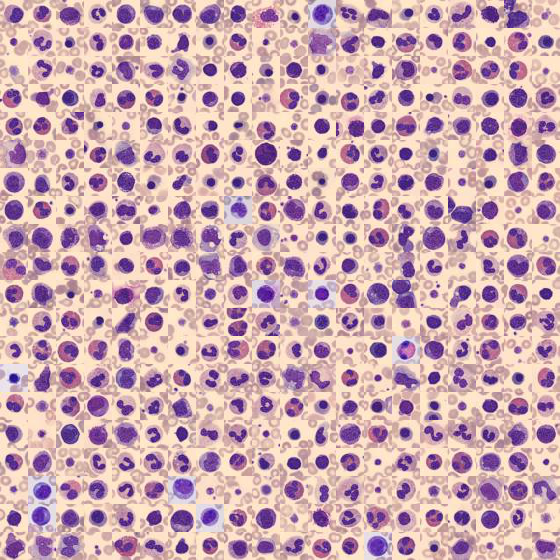

In [31]:
# montage
train_dataset.montage(length=20)

# 3. Training and evaluation functions
In this section, we build the training loop for our CNN model

## 3.1 Train function

In [32]:
def train(net, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS,
                   checkpoint_flag, patience=5, validation_interval=1, early_stopping_counter=0,step_size=3, gamma=.9):
    
    # scheduler initialization
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Adjust step_size and gamma as needed

    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    best_f1 = 0.0
    
    for epoch in range(NUM_EPOCHS):
        net.train()
        epoch_train_loss = 0.0
        
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = net(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Calculate average training loss for this epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        #scheduler for gamma implementation
        scheduler.step()
        
        if (epoch + 1) % validation_interval == 0:
            net.eval()
            y_true = []
            y_pred = []
            epoch_val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader):
                    outputs = net(inputs)
                    predicted = torch.argmax(outputs, dim=1)
                    y_true.extend(targets.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())
                    val_loss = criterion(outputs, targets.squeeze().long())
                    epoch_val_loss += val_loss.item()

            # Calculate average validation loss for this epoch
            epoch_val_loss /= len(val_loader)
            val_losses.append(epoch_val_loss)

            f1 = f1_score(y_true, y_pred, average='weighted')

            print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}] - Validation F1 Score: {f1:.4f} Previous Best F1 Score {best_f1:.4f}')

            # Early stopping mechanism
            if f1 > best_f1:
                best_f1 = f1
                early_stopping_counter = 0
                torch.save(net.state_dict(), 'CNN_checkpoint/' + checkpoint_flag + '.pt')
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print('Early stopping! F1 score did not improve for {} consecutive epochs.'.format(patience * validation_interval))
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.grid(True)
    plt.show()



## 3.2 Model Evaluation and Testing funciton

In [33]:
def test(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_score = y_score.detach().numpy()

        #evaluation metrics
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        classification_report_str = classification_report(y_true, y_pred, target_names=info['label'])

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        print('Classification Report:')
        print(classification_report_str)

        #confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# 4. Building a simple CNN model
In this section, we learn to define a simple CNN model using the main layers for this purpose. 

## 4.1 Model

In [34]:
# define a simple CNN model

# Building the model class (in this case we will name it Net)
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
    
        # define the layers composing our model (don't forget to add
        ## the self in the definition so that we can later refer
        ## to them in the forward method). We can define
        ## them in two main ways in PyTorch:
        ## 1. Each layer separately
        self.layer1 = nn.Conv2d(in_channels, 16, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(16)
        self_relu1 = nn.ReLU()
        
        # 2. A sequence of layers as a nn.Sequential object
        self.fc = nn.Sequential(
            nn.Linear(16*26*26, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    # the forward method (actions to be taken when the model
    ## is applied)
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define the alex_net
model = Net(in_channels=n_channels, num_classes=n_classes)

In [35]:
# Visualizing our model architecture:
model

Net(
  (layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=10816, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=8, bias=True)
  )
)

## 4.2 Model Training

In [36]:
##load another the saved model
#model.load_state_dict(torch.load('CNN_checkpoint/model1.pt'))

In [37]:
# Define loss function
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #, weight_decay=0.00001 commented out due to terrible results

100%|██████████| 14/14 [00:00<00:00, 24.96it/s]


Epoch [1/30] - Validation F1 Score: 0.3994 Previous Best F1 Score 0.0000


100%|██████████| 14/14 [00:00<00:00, 27.19it/s]


Epoch [2/30] - Validation F1 Score: 0.5560 Previous Best F1 Score 0.3994


100%|██████████| 14/14 [00:00<00:00, 28.80it/s]


Epoch [3/30] - Validation F1 Score: 0.6407 Previous Best F1 Score 0.5560


100%|██████████| 14/14 [00:00<00:00, 35.00it/s]


Epoch [4/30] - Validation F1 Score: 0.6871 Previous Best F1 Score 0.6407


100%|██████████| 14/14 [00:00<00:00, 31.20it/s]


Epoch [5/30] - Validation F1 Score: 0.7029 Previous Best F1 Score 0.6871


100%|██████████| 14/14 [00:00<00:00, 36.27it/s]


Epoch [6/30] - Validation F1 Score: 0.7237 Previous Best F1 Score 0.7029


100%|██████████| 14/14 [00:00<00:00, 28.80it/s]


Epoch [7/30] - Validation F1 Score: 0.7272 Previous Best F1 Score 0.7237


100%|██████████| 14/14 [00:00<00:00, 36.84it/s]


Epoch [8/30] - Validation F1 Score: 0.7267 Previous Best F1 Score 0.7272


100%|██████████| 14/14 [00:00<00:00, 33.51it/s]


Epoch [9/30] - Validation F1 Score: 0.7519 Previous Best F1 Score 0.7272


100%|██████████| 14/14 [00:00<00:00, 35.44it/s]


Epoch [10/30] - Validation F1 Score: 0.7489 Previous Best F1 Score 0.7519


100%|██████████| 14/14 [00:00<00:00, 38.26it/s]


Epoch [11/30] - Validation F1 Score: 0.7594 Previous Best F1 Score 0.7519


100%|██████████| 14/14 [00:00<00:00, 34.99it/s]


Epoch [12/30] - Validation F1 Score: 0.7611 Previous Best F1 Score 0.7594


100%|██████████| 14/14 [00:00<00:00, 30.90it/s]


Epoch [13/30] - Validation F1 Score: 0.7749 Previous Best F1 Score 0.7611


100%|██████████| 14/14 [00:00<00:00, 37.88it/s]


Epoch [14/30] - Validation F1 Score: 0.7915 Previous Best F1 Score 0.7749


100%|██████████| 14/14 [00:00<00:00, 38.73it/s]


Epoch [15/30] - Validation F1 Score: 0.7908 Previous Best F1 Score 0.7915


100%|██████████| 14/14 [00:00<00:00, 35.67it/s]


Epoch [16/30] - Validation F1 Score: 0.7941 Previous Best F1 Score 0.7915


100%|██████████| 14/14 [00:00<00:00, 37.73it/s]


Epoch [17/30] - Validation F1 Score: 0.7996 Previous Best F1 Score 0.7941


100%|██████████| 14/14 [00:00<00:00, 38.60it/s]


Epoch [18/30] - Validation F1 Score: 0.8105 Previous Best F1 Score 0.7996


100%|██████████| 14/14 [00:00<00:00, 32.26it/s]


Epoch [19/30] - Validation F1 Score: 0.8028 Previous Best F1 Score 0.8105


100%|██████████| 14/14 [00:00<00:00, 39.53it/s]


Epoch [20/30] - Validation F1 Score: 0.8110 Previous Best F1 Score 0.8105


100%|██████████| 14/14 [00:00<00:00, 30.59it/s]


Epoch [21/30] - Validation F1 Score: 0.8123 Previous Best F1 Score 0.8110


100%|██████████| 14/14 [00:00<00:00, 36.39it/s]


Epoch [22/30] - Validation F1 Score: 0.8203 Previous Best F1 Score 0.8123


100%|██████████| 14/14 [00:00<00:00, 33.46it/s]


Epoch [23/30] - Validation F1 Score: 0.8102 Previous Best F1 Score 0.8203


100%|██████████| 14/14 [00:00<00:00, 35.30it/s]


Epoch [24/30] - Validation F1 Score: 0.8173 Previous Best F1 Score 0.8203


100%|██████████| 14/14 [00:00<00:00, 38.97it/s]


Epoch [25/30] - Validation F1 Score: 0.8178 Previous Best F1 Score 0.8203


100%|██████████| 14/14 [00:00<00:00, 38.48it/s]


Epoch [26/30] - Validation F1 Score: 0.8172 Previous Best F1 Score 0.8203


100%|██████████| 14/14 [00:00<00:00, 38.69it/s]


Epoch [27/30] - Validation F1 Score: 0.8280 Previous Best F1 Score 0.8203


100%|██████████| 14/14 [00:00<00:00, 38.33it/s]


Epoch [28/30] - Validation F1 Score: 0.8215 Previous Best F1 Score 0.8280


100%|██████████| 14/14 [00:00<00:00, 39.09it/s]


Epoch [29/30] - Validation F1 Score: 0.8200 Previous Best F1 Score 0.8280


100%|██████████| 14/14 [00:00<00:00, 33.68it/s]


Epoch [30/30] - Validation F1 Score: 0.8284 Previous Best F1 Score 0.8280


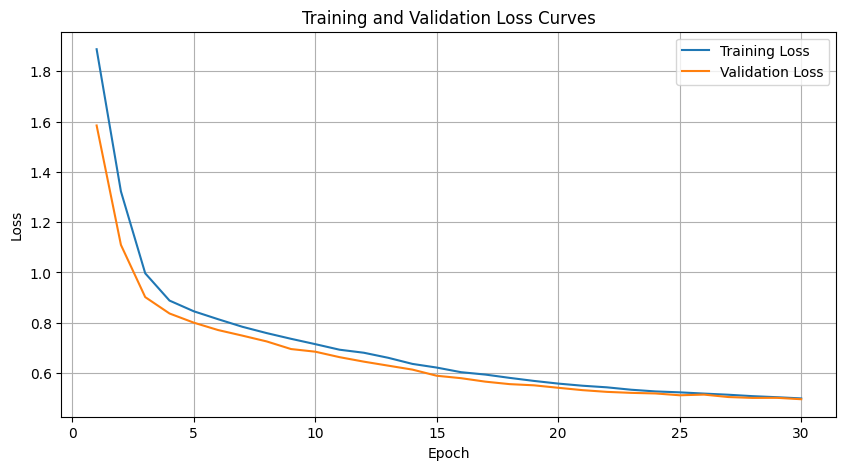

In [38]:
# Training model with gamma 0.85 to reduce gradient descent
train(model,train_loader,val_loader,optimizer,criterion,NUM_EPOCHS, 'model1', step_size=3, gamma=0.85)

## 4.3 Model Testing

==> Evaluating ...
train  auc: 0.975  acc:0.830
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       852
           1       0.95      0.95      0.95      2181
           2       0.86      0.76      0.81      1085
           3       0.65      0.75      0.70      2026
           4       0.81      0.72      0.76       849
           5       0.69      0.65      0.67       993
           6       0.89      0.91      0.90      2330
           7       0.98      0.99      0.98      1643

    accuracy                           0.83     11959
   macro avg       0.81      0.79      0.80     11959
weighted avg       0.83      0.83      0.83     11959



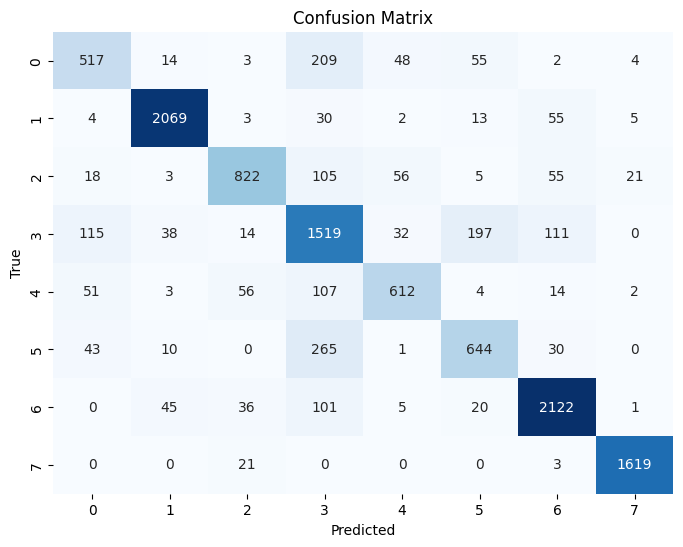

test  auc: 0.971  acc:0.811
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       244
           1       0.92      0.93      0.93       624
           2       0.85      0.78      0.81       311
           3       0.60      0.72      0.65       579
           4       0.83      0.70      0.76       243
           5       0.65      0.60      0.62       284
           6       0.87      0.89      0.88       666
           7       0.98      0.99      0.99       470

    accuracy                           0.81      3421
   macro avg       0.80      0.77      0.78      3421
weighted avg       0.82      0.81      0.81      3421



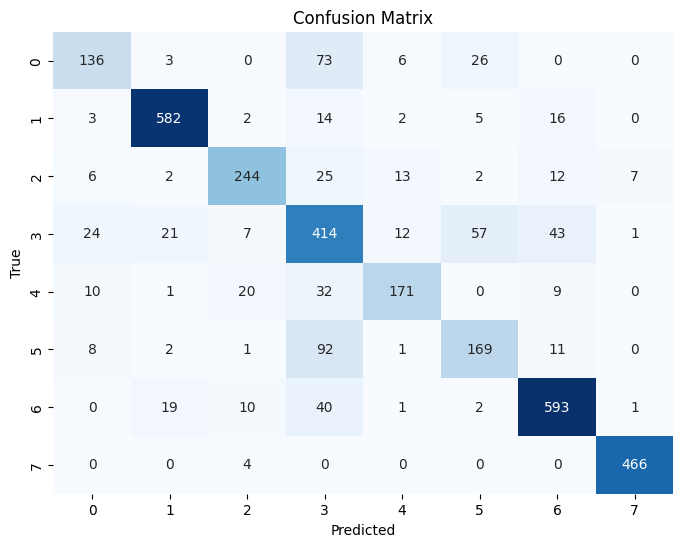

In [39]:
# Loading simple model weights to evaluate model
model.load_state_dict(torch.load('CNN_checkpoint/model1.pt'))
print('==> Evaluating ...')
test('train',model)
test('test',model)

# 5. Alex Net

## 5.1 Model

In [40]:
class SimpleAlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleAlexNet, self).__init__()

        # Layer 1: Convolutional and Max-Pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 18, kernel_size=5, stride=1, padding=2),  # Reduced filters to 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))

        # Layer 2: Convolutional
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 32, kernel_size=5, stride=1, padding=2),  # Reduced filters to 64
            nn.ReLU())

        # Fully Connected Layers (Adjusted Input and Output Sizes)
        self.fc = nn.Sequential(
            nn.Linear(32 * 27 * 27, 32),  # Adjusted input size to match the flattened feature vector
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes))  # Reduced neurons

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Define the model
simple_alex_net = SimpleAlexNet(in_channels=n_channels, num_classes=n_classes)

## 5.1 Train Simple_Alex_Net

In [41]:
# Define loss function
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
# Incorporating the weight_decay to the optimzer funciton to limit big weights
optimizer = optim.SGD(simple_alex_net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.0001)

In [42]:
#simple_alex_net.load_state_dict(torch.load('CNN_checkpoint/alex_net.pt'))

100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


Epoch [1/30] - Validation F1 Score: 0.2998 Previous Best F1 Score 0.0000


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


Epoch [2/30] - Validation F1 Score: 0.5751 Previous Best F1 Score 0.2998


100%|██████████| 14/14 [00:01<00:00, 10.16it/s]


Epoch [3/30] - Validation F1 Score: 0.6357 Previous Best F1 Score 0.5751


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


Epoch [4/30] - Validation F1 Score: 0.6471 Previous Best F1 Score 0.6357


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


Epoch [5/30] - Validation F1 Score: 0.7064 Previous Best F1 Score 0.6471


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


Epoch [6/30] - Validation F1 Score: 0.6846 Previous Best F1 Score 0.7064


100%|██████████| 14/14 [00:01<00:00,  9.15it/s]


Epoch [7/30] - Validation F1 Score: 0.6853 Previous Best F1 Score 0.7064


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


Epoch [8/30] - Validation F1 Score: 0.7312 Previous Best F1 Score 0.7064


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


Epoch [9/30] - Validation F1 Score: 0.7324 Previous Best F1 Score 0.7312


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


Epoch [10/30] - Validation F1 Score: 0.7533 Previous Best F1 Score 0.7324


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


Epoch [11/30] - Validation F1 Score: 0.7622 Previous Best F1 Score 0.7533


100%|██████████| 14/14 [00:01<00:00,  9.47it/s]


Epoch [12/30] - Validation F1 Score: 0.7707 Previous Best F1 Score 0.7622


100%|██████████| 14/14 [00:01<00:00,  9.37it/s]


Epoch [13/30] - Validation F1 Score: 0.8035 Previous Best F1 Score 0.7707


100%|██████████| 14/14 [00:01<00:00,  9.40it/s]


Epoch [14/30] - Validation F1 Score: 0.7884 Previous Best F1 Score 0.8035


100%|██████████| 14/14 [00:01<00:00,  9.33it/s]


Epoch [15/30] - Validation F1 Score: 0.7805 Previous Best F1 Score 0.8035


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


Epoch [16/30] - Validation F1 Score: 0.8204 Previous Best F1 Score 0.8035


100%|██████████| 14/14 [00:01<00:00,  9.73it/s]


Epoch [17/30] - Validation F1 Score: 0.8357 Previous Best F1 Score 0.8204


100%|██████████| 14/14 [00:01<00:00,  9.45it/s]


Epoch [18/30] - Validation F1 Score: 0.8377 Previous Best F1 Score 0.8357


100%|██████████| 14/14 [00:01<00:00,  9.49it/s]


Epoch [19/30] - Validation F1 Score: 0.8277 Previous Best F1 Score 0.8377


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch [20/30] - Validation F1 Score: 0.8270 Previous Best F1 Score 0.8377


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch [21/30] - Validation F1 Score: 0.8365 Previous Best F1 Score 0.8377


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


Epoch [22/30] - Validation F1 Score: 0.8359 Previous Best F1 Score 0.8377


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch [23/30] - Validation F1 Score: 0.8108 Previous Best F1 Score 0.8377
Early stopping! F1 score did not improve for 5 consecutive epochs.


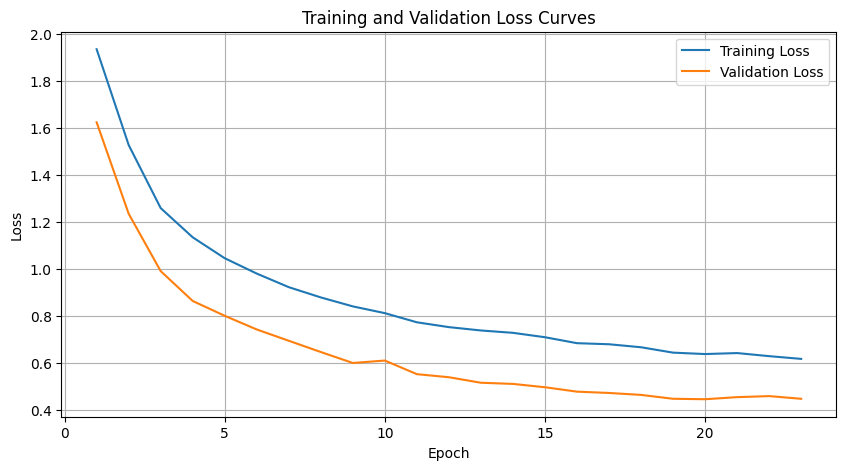

In [43]:
# Incorporating training function with gamma parrameter wich is preset to zero to experiment with convergence and model results
train(simple_alex_net,train_loader,val_loader,optimizer,criterion,NUM_EPOCHS, 'alex_net', step_size=5, gamma=0.95)

## 5.2 Test Simple_Alex_Net

==> Evaluating ...
train  auc: 0.976  acc:0.834
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       852
           1       0.97      0.97      0.97      2181
           2       0.89      0.74      0.81      1085
           3       0.63      0.74      0.68      2026
           4       0.79      0.74      0.77       849
           5       0.63      0.59      0.61       993
           6       0.93      0.96      0.94      2330
           7       0.97      0.99      0.98      1643

    accuracy                           0.83     11959
   macro avg       0.82      0.79      0.80     11959
weighted avg       0.84      0.83      0.83     11959



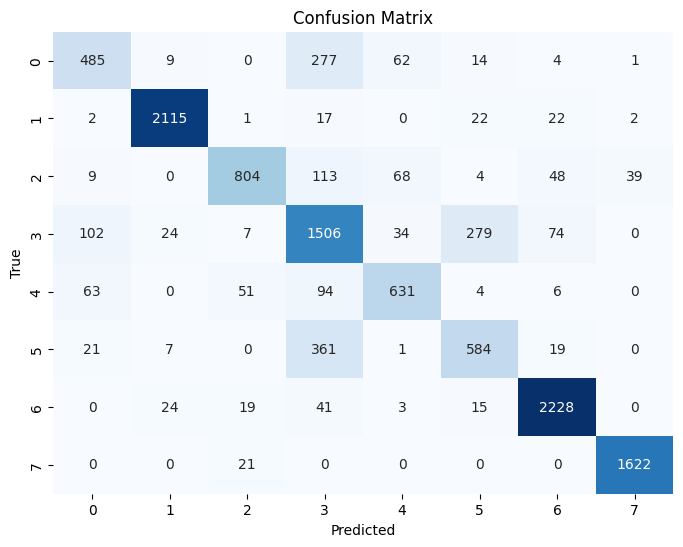

test  auc: 0.972  acc:0.826
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.51      0.58       244
           1       0.96      0.97      0.97       624
           2       0.87      0.76      0.81       311
           3       0.59      0.73      0.65       579
           4       0.82      0.74      0.78       243
           5       0.64      0.58      0.61       284
           6       0.93      0.95      0.94       666
           7       0.97      0.99      0.98       470

    accuracy                           0.83      3421
   macro avg       0.81      0.78      0.79      3421
weighted avg       0.83      0.83      0.83      3421



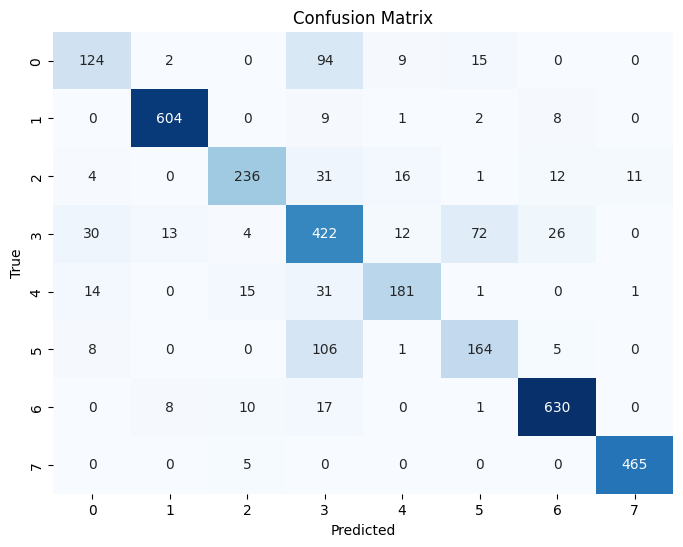

In [44]:
# Loading weights for evaluation
simple_alex_net.load_state_dict(torch.load('CNN_checkpoint/alex_net.pt'))
print('==> Evaluating ...')
test('train',simple_alex_net)
test('test',simple_alex_net)

# 6. Res Net

## 6.1 Model

In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNetNoDownsampling(nn.Module):
    def __init__(self, num_residual_blocks=10, num_classes=10):
        super(ResNetNoDownsampling, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.blocks = self._make_layers(16, num_residual_blocks)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def _make_layers(self, in_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(in_channels, 16))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Create the model
resnet = ResNetNoDownsampling(num_residual_blocks=10, num_classes=n_classes)

In [46]:
# model architecture
resnet

ResNetNoDownsampling(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-0

## 6.2 Resnet Train

In [47]:
# Define loss function
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=0.9)

In [48]:
#resnet.load_state_dict(torch.load('CNN_checkpoint/ResNetNoDownsampling.pt'))

100%|██████████| 14/14 [00:02<00:00,  5.25it/s]


Epoch [1/30] - Validation F1 Score: 0.5499 Previous Best F1 Score 0.0000


100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch [2/30] - Validation F1 Score: 0.7216 Previous Best F1 Score 0.5499


100%|██████████| 14/14 [00:02<00:00,  4.99it/s]


Epoch [3/30] - Validation F1 Score: 0.7913 Previous Best F1 Score 0.7216


100%|██████████| 14/14 [00:02<00:00,  5.10it/s]


Epoch [4/30] - Validation F1 Score: 0.8518 Previous Best F1 Score 0.7913


100%|██████████| 14/14 [00:02<00:00,  4.99it/s]


Epoch [5/30] - Validation F1 Score: 0.8386 Previous Best F1 Score 0.8518


100%|██████████| 14/14 [00:02<00:00,  5.13it/s]


Epoch [6/30] - Validation F1 Score: 0.6763 Previous Best F1 Score 0.8518


100%|██████████| 14/14 [00:02<00:00,  5.13it/s]


Epoch [7/30] - Validation F1 Score: 0.8330 Previous Best F1 Score 0.8518


100%|██████████| 14/14 [00:02<00:00,  5.09it/s]


Epoch [8/30] - Validation F1 Score: 0.8730 Previous Best F1 Score 0.8518


100%|██████████| 14/14 [00:02<00:00,  5.19it/s]


Epoch [9/30] - Validation F1 Score: 0.8275 Previous Best F1 Score 0.8730


100%|██████████| 14/14 [00:02<00:00,  5.15it/s]


Epoch [10/30] - Validation F1 Score: 0.8482 Previous Best F1 Score 0.8730


100%|██████████| 14/14 [00:02<00:00,  5.02it/s]


Epoch [11/30] - Validation F1 Score: 0.4992 Previous Best F1 Score 0.8730


100%|██████████| 14/14 [00:02<00:00,  5.10it/s]


Epoch [12/30] - Validation F1 Score: 0.8835 Previous Best F1 Score 0.8730


100%|██████████| 14/14 [00:02<00:00,  5.06it/s]


Epoch [13/30] - Validation F1 Score: 0.7784 Previous Best F1 Score 0.8835


100%|██████████| 14/14 [00:02<00:00,  5.12it/s]


Epoch [14/30] - Validation F1 Score: 0.9088 Previous Best F1 Score 0.8835


100%|██████████| 14/14 [00:03<00:00,  3.99it/s]


Epoch [15/30] - Validation F1 Score: 0.8494 Previous Best F1 Score 0.9088


100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [16/30] - Validation F1 Score: 0.9213 Previous Best F1 Score 0.9088


100%|██████████| 14/14 [00:03<00:00,  4.02it/s]


Epoch [17/30] - Validation F1 Score: 0.8718 Previous Best F1 Score 0.9213


100%|██████████| 14/14 [00:03<00:00,  3.95it/s]


Epoch [18/30] - Validation F1 Score: 0.8951 Previous Best F1 Score 0.9213


100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


Epoch [19/30] - Validation F1 Score: 0.6218 Previous Best F1 Score 0.9213


100%|██████████| 14/14 [00:03<00:00,  3.99it/s]


Epoch [20/30] - Validation F1 Score: 0.8743 Previous Best F1 Score 0.9213


100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


Epoch [21/30] - Validation F1 Score: 0.9284 Previous Best F1 Score 0.9213


100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


Epoch [22/30] - Validation F1 Score: 0.8483 Previous Best F1 Score 0.9284


100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch [23/30] - Validation F1 Score: 0.8835 Previous Best F1 Score 0.9284


100%|██████████| 14/14 [00:03<00:00,  4.37it/s]


Epoch [24/30] - Validation F1 Score: 0.9179 Previous Best F1 Score 0.9284


100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


Epoch [25/30] - Validation F1 Score: 0.9375 Previous Best F1 Score 0.9284


100%|██████████| 14/14 [00:03<00:00,  4.34it/s]


Epoch [26/30] - Validation F1 Score: 0.9267 Previous Best F1 Score 0.9375


100%|██████████| 14/14 [00:03<00:00,  4.20it/s]


Epoch [27/30] - Validation F1 Score: 0.8308 Previous Best F1 Score 0.9375


100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


Epoch [28/30] - Validation F1 Score: 0.8933 Previous Best F1 Score 0.9375


100%|██████████| 14/14 [00:04<00:00,  3.44it/s]


Epoch [29/30] - Validation F1 Score: 0.8891 Previous Best F1 Score 0.9375


100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


Epoch [30/30] - Validation F1 Score: 0.8705 Previous Best F1 Score 0.9375
Early stopping! F1 score did not improve for 5 consecutive epochs.


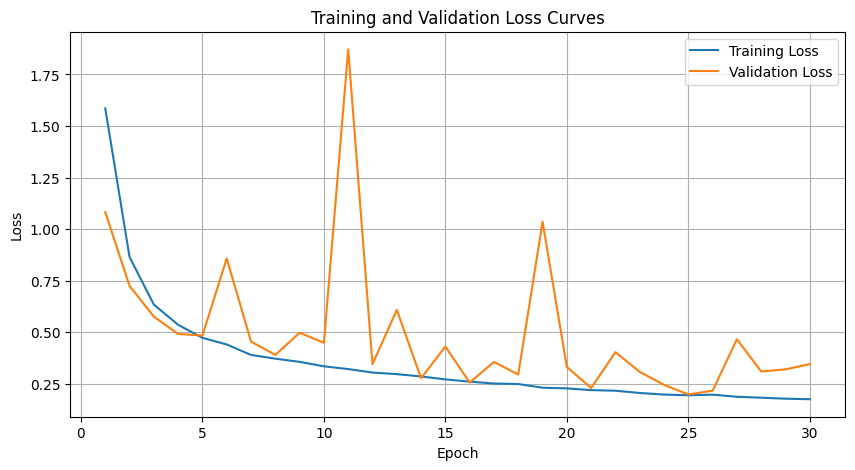

In [49]:
# Training with predefined function
train(resnet, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS, 'ResNetNoDownsampling')

## 6.2 Resnet Eval

==> Evaluating ...
train  auc: 0.997  acc:0.941
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       852
           1       1.00      0.99      0.99      2181
           2       0.97      0.93      0.95      1085
           3       0.87      0.88      0.87      2026
           4       0.87      0.97      0.92       849
           5       0.81      0.88      0.84       993
           6       0.99      0.96      0.98      2330
           7       0.99      1.00      1.00      1643

    accuracy                           0.94     11959
   macro avg       0.93      0.93      0.93     11959
weighted avg       0.94      0.94      0.94     11959



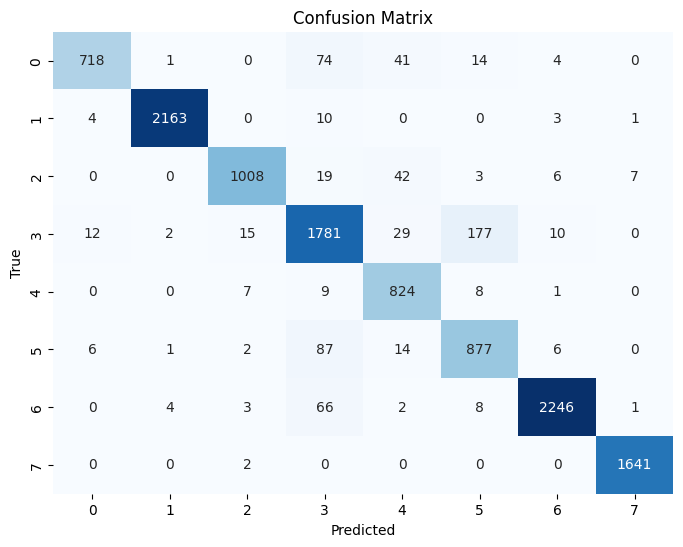

test  auc: 0.994  acc:0.930
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       244
           1       0.99      0.99      0.99       624
           2       0.96      0.92      0.94       311
           3       0.85      0.84      0.84       579
           4       0.87      0.96      0.91       243
           5       0.78      0.87      0.82       284
           6       0.98      0.95      0.97       666
           7       0.99      1.00      1.00       470

    accuracy                           0.93      3421
   macro avg       0.92      0.92      0.92      3421
weighted avg       0.93      0.93      0.93      3421



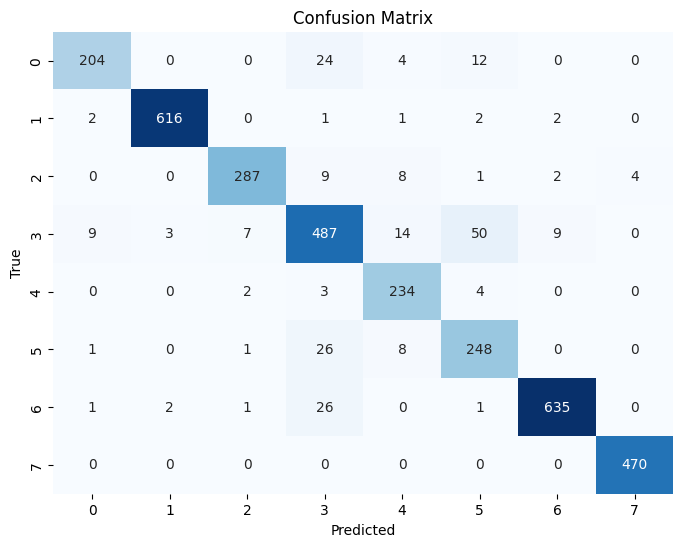

In [50]:
# Loading best weights to evaluate model
resnet.load_state_dict(torch.load('CNN_checkpoint/ResNetNoDownsampling.pt'))
print('==> Evaluating ...')
test('train',resnet)
test('test',resnet)

# 7. Conv layers visualizaiton

In [51]:
model.load_state_dict(torch.load('CNN_checkpoint/model1.pt'))
simple_alex_net.load_state_dict(torch.load('CNN_checkpoint/alex_net.pt'))
resnet.load_state_dict(torch.load('CNN_checkpoint/ResNetNoDownsampling.pt'))

<All keys matched successfully>

## 7.1 Filter Visualization

In [52]:

#plot filter
def plot_filters(layer):
    filters = layer.weight.data.cpu().numpy()
    num_filters = filters.shape[0]

    # Plot each filter
    for i in range(num_filters):
        plt.subplot(1, num_filters, i+1)
        plt.imshow(filters[i][0], cmap='gray')
        plt.axis('off')

#Visualize the conv layer filters
def visualize_filters(model):
    # Access convolutional layers
    layers = [model.layer1[0], model.layer2[0]]

    # Plot the filters for each convolutional layer
    for i, layer in enumerate(layers):
        plt.figure(figsize=(10, 3))
        plt.suptitle(f'Layer {i+1} Filters')
        plot_filters(layer)

#Visualize image given layer output
def feature_map(output):
    output_1 = output[0, :, :, :].detach().numpy()
    num_images = output_1.shape[0]

        # Create subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4)) 

    # Iterate through the images and display each one
    for i in range(num_images):
        axes[i].imshow(output_1[i], cmap='gray') 
        axes[i].set_title(f"{i + 1}")
        axes[i].axis('off') 

    plt.show()

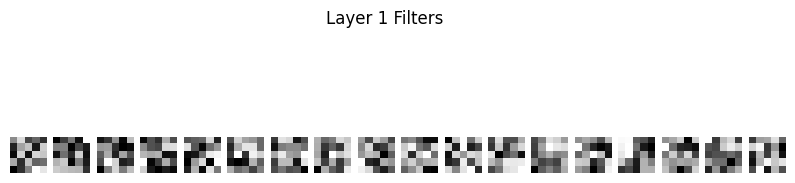

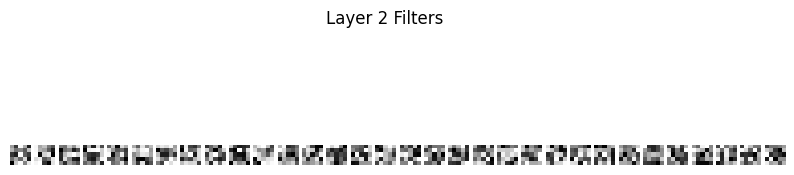

In [53]:
# Visualizing Conv filters that create feature maps
visualize_filters(simple_alex_net)

## 7.2 Simple CNN feature maps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28, 3)


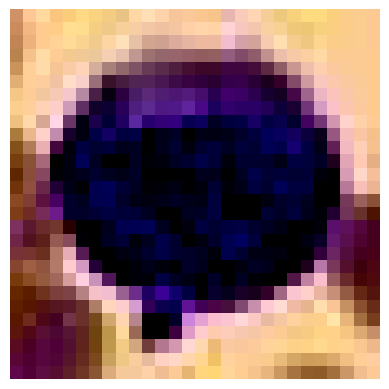

In [54]:
# Visualizing image that will be fed through the the Conv layers to extract feature maps
simple_alex_net
simple_alex_net.eval()

data_iter = iter(test_loader)
batch = next(data_iter)
images, labels = batch

image = images[0].permute(1, 2, 0).numpy()

print(image.shape)

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

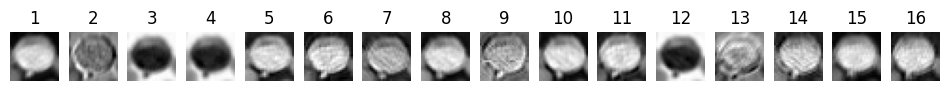

In [55]:
# Model one feature maps
output = model.layer1(images)
feature_map(output)

## 7.3 Alex_net Feature Maps

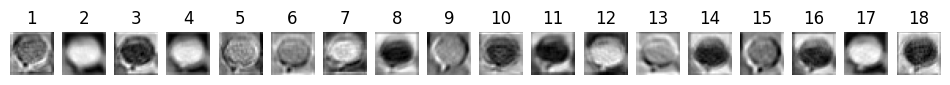

In [56]:
# Alex net feature maps
output = simple_alex_net.layer1[0](images)
feature_map(output)

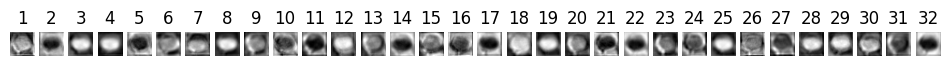

In [57]:
# Feeding the output of one conv layer into the next one to create feature maps
# Layer two feature maps
output = simple_alex_net.layer2[0](simple_alex_net.layer1(images))
feature_map(output)

# 8. Conclusion
After training three models, including a simple CNN, AlexNet, and ResNet, I can confidently conclude that the traditional ResNet and AlexNet architectures, which rely on max pooling and average pooling for feature extraction, exhibited reduced efficacy for my dataset. These architectures demonstrated slower convergence rates and did not consistently the base model without hyperparameter tuning. Experimenting with hyperparameters did not yield significant improvements; instead, it often resulted in slower convergence and lower overall performance. In the case of AlexNet, I had to simplify it significantly due to limitations in image dimensions caused by max pooling which might be one of the reasons for its low performance. In contrast, ResNet had to maintain dimensionality throughout the model because any form of pooling would have drastically reduced information flow, potentially resulting in a one-pixel output.

Given that this dataset pertains to medical diagnosis, prioritizing recall is paramount. Missing a positive diagnosis carries more severe consequences than generating a false positive. Clinicians can review and dismiss false positives, but a missed diagnosis might be challenging to identify manually among numerous images or negatives. Therefore, it is crucial to maximize the recall rate. In this context, my best-performing model was ResNet, with an average recall score of 0.93. ResNet consistently outperformed the other models. Its deep architecture allowed it to learn and retain complex patterns across its multiple layers, contributing to its superior and consistent image classification performance.

Finally the simplicity of the AlexNet and simple CNN allowed me to quickly and efficiently extract the feature maps of the the models to visualize them, which gave the project flavor, and a deeper understanding of the functioning of CNN's.

Overall this homework was very intuitive in helping me understand CNN's and Deep neural networks overall. This was a great challenge for me due to my lack of experience in the field but I welcomed the task with determination and the dedication to spend as much time as needed to make sure that completed teh full assignment, even the extra parts to be able carry out what I learnt outside of the classroom.